##### Author: Pablo Iañez Picazo 
##### Biomedical Data Science lab, ISGlobal

In [1]:
# Load all the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans

import random
import umap

random.seed(22)
sns.set_style("ticks")

# Supress all warnings (bcoz they're quite annoying)
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("/home/pianez/phd/projects/hsc_nucleus/hsc_rhoa")
from methods import hsc_spatial_stats as hsc
from globals import batches_out, new_names

2025-07-09 10:33:16.919645: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 10:33:16.946981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 10:33:16.947003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 10:33:16.947720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 10:33:16.952454: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set(rc={"figure.figsize": (20, 16)})
sns.set_style("whitegrid")

In [3]:
# ------------------------ Set up some parameters --------------------------- #
# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1
# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6
norm = "z_score"
folder = "../data/preprocessed/"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "myeloid_progenitors",
]

palette = {
    "Young": (0.00392, 0.45098, 0.69803),
    "Aged": (0.00784, 0.61960, 0.45098),
    "Aged + Ri": (0.8, 0.47058, 0.73725),
}

In [4]:
nuc_df = pd.read_csv(
    f"results/z_score_nuclei_3d_res{res}_cf{cft}_filt_df.csv", index_col=0
)
nuc_df = hsc.fix_labels(nuc_df)

In [5]:
MP_batches = [
    "20210120_PHF8-OldAB",
    "20210414_KDM4B",
    "20210429_H3K9me2-Cy3",
    "20211203_KDM3A",
    "20210421_PHF8-OldAB",
    "20210916_KDM3A_2",
    "20201109_KDM4B",
    "20210126_KDM4A_2",
    "20210831_H3K9me2",
    "20210122_PHF8-NewAB",
    "20210114_KDM4B",
    "20210430_PHF8-OldAB",
    "20210415_KDM4A",
    "20210126_KDM4A",
    "20210121_PHF8-NewAB",
    "20210505_H3K9me2",
    "20210112_H3K9me2",
    "20210916_KDM3A",
]

In [6]:
print(nuc_df.shape)
nuc_df = nuc_df[~nuc_df["im_batch"].isin(batches_out)]
print(nuc_df.shape)

(837, 92)
(780, 92)


In [7]:
features = [
    "volume",
    "width",
    "length",
    "height",
    "height deviation",
    "aspect ratio",
    "major axis length",
    "minor axis length",
    "min intensity",
    "max intensity",
    "solidity",
    "surface area",  # highly correlated with volume
    "sphericity",
    "invagination proportion",  # highly correlated with solidity
    "DIRs volume",
    "DIRs width",
    "DIRs length",
    "DIRs height",
    "intensity 0-0.5µm",
    "intensity 1-1.5µm",
    "intensity ratio",
    "DIRs aspect ratio",
    "DIRs surface area",
    "DIRs major axis length",
    "DIRs sphericity",
    "DIRs surface/volume",
    "DIRs mean intensity",
    "DIRs max intensity",
    "DIRs solidity",
    "DIRs centroid distance to border",  # highly correlated with DIRs_mean_distance2border
    "DIRs distance to border",
    "number of DIRs",
    "largest slide area",  # highly correlated with 2D_slide_volume
    "largest slide major axis length",
    "largest slide minor axis length",
    "largest slide perimeter",  # highly correlated with 2D_slide_area
    "largest slide roundness",  # highly correlated with 2D_slide_EOP
    "largest slide compactness",
    "largest slide EOP",
    "condition",
    "im_path",
    "im_batch",
    "im_nuc",
]

# Those features commented are the one filtered out during correlation analyses
sig_f_both = [
    "volume",
    "width",
    "length",
    "aspect ratio",
    "minor axis length",
    "min intensity",
    # "surface_area",
    "sphericity",
    "DIRs volume",
    "DIRs length",
    # "DIRs_height",
    "intensity 0-0.5µm",
    # "int_1.0-1.5",
    "intensity ratio",
    "DIRs major axis length",
    "DIRs mean intensity",
    # "DIRs_max_intensity",
    "DIRs sphericity",
    # "DIRs_surface/volume",
    "DIRs solidity",
    "number of DIRs",
    # "DIRs_centroid_distance2border",
    "DIRs distance to border",
    # "2D_slide_area",
    "largest slide major axis length",
    "largest slide minor axis length",
    # "2D_slide_perimeter",
    # "2D_slide_roundness",
    "largest slide EOP",
]

In [8]:
# nuc_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri", "MP"])]
subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]
subset_df = subset_df.rename(columns=new_names)
subset_df = subset_df[features]
subset_df["DIRs distance to border"] = (
    subset_df["DIRs distance to border"] * res
)

In [9]:
subset_df.condition.value_counts()

condition
Young        177
Aged         164
Aged + Ri    144
Name: count, dtype: int64

In [10]:
corrmat = subset_df[sig_f_both].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis=1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ["var_1", "var_2", "correlation"]
corrmat = corrmat[corrmat["correlation"] != 1]
corrmat.sort_values(by="correlation", ascending=False).head(20)

,var_1,var_2,correlation
80,minor axis length,volume,0.766306
4,volume,minor axis length,0.766306
190,intensity 0-0.5µm,intensity ratio,0.723796
209,intensity ratio,intensity 0-0.5µm,0.723796
151,DIRs volume,DIRs major axis length,0.705157
227,DIRs major axis length,DIRs volume,0.705157
360,largest slide minor axis length,volume,0.687662
18,volume,largest slide minor axis length,0.687662
364,largest slide minor axis length,minor axis length,0.684031
98,minor axis length,largest slide minor axis length,0.684031


In [11]:
corrmat.sort_values(by="correlation", ascending=False).tail(20)

,var_1,var_2,correlation
139,sphericity,largest slide EOP,-0.450413
386,largest slide EOP,sphericity,-0.450413
363,largest slide minor axis length,aspect ratio,-0.474527
78,aspect ratio,largest slide minor axis length,-0.474527
308,number of DIRs,DIRs length,-0.491506
175,DIRs length,number of DIRs,-0.491506
216,intensity ratio,DIRs distance to border,-0.520285
330,DIRs distance to border,intensity ratio,-0.520285
235,DIRs major axis length,number of DIRs,-0.549880
311,number of DIRs,DIRs major axis length,-0.549880


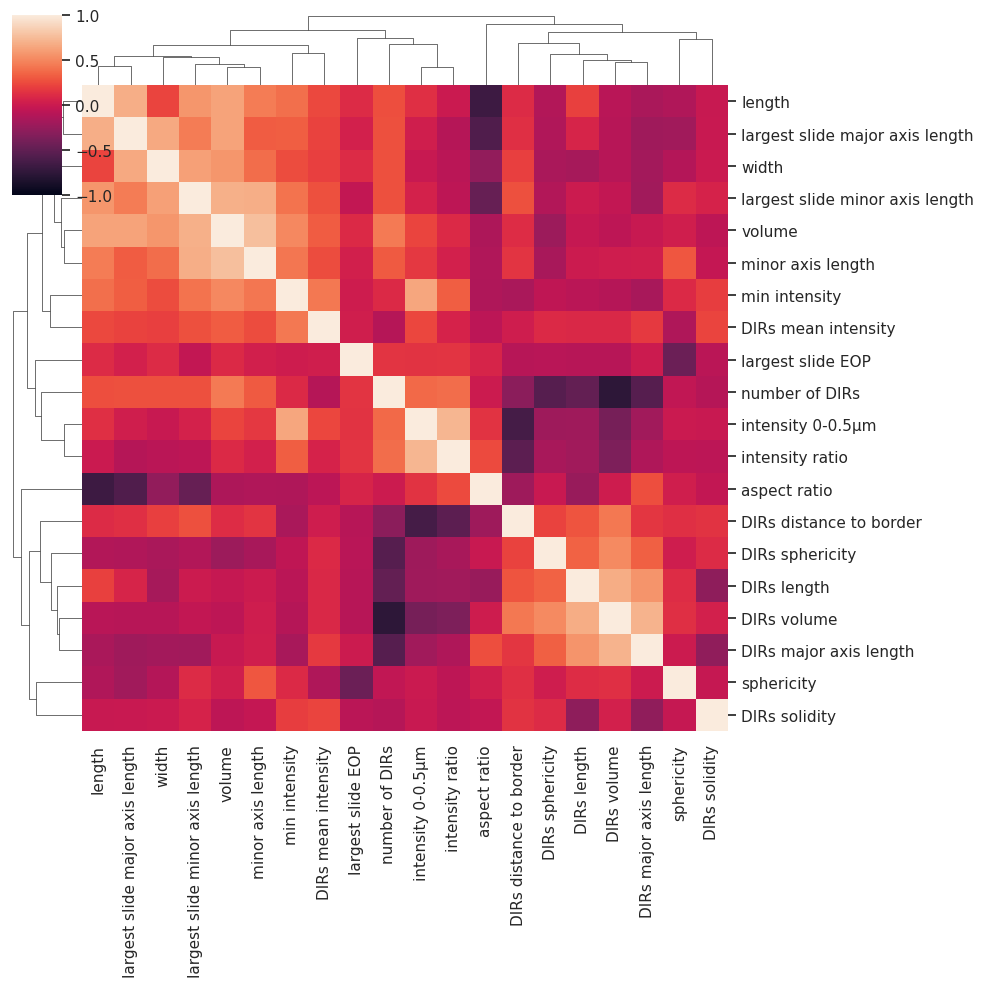

In [12]:
sns.clustermap(
    subset_df[sig_f_both].corr(), dendrogram_ratio=0.1, vmin=-1, vmax=1
)

In [13]:
corr_matrix = subset_df[sig_f_both].corr()

# Create mask to exclude diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Calculate average absolute correlation excluding diagonal
avg_abs_corr = corr_matrix.abs().where(mask).stack().mean()
print(f"Average absolute correlation (excluding diagonal): {avg_abs_corr:.2f}")

Average absolute correlation (excluding diagonal): 0.22


In [14]:
subset_df.reset_index(drop=True, inplace=True)
subset_df.condition.value_counts()

condition
Young        177
Aged         164
Aged + Ri    144
Name: count, dtype: int64

In [15]:
# Printing our number of samples vs. number of features
dims_df = subset_df[subset_df.columns[:-4]]
dims_df[sig_f_both]

,volume,width,length,aspect ratio,minor axis length,min intensity,sphericity,DIRs volume,DIRs length,intensity 0-0.5µm,intensity ratio,DIRs major axis length,DIRs mean intensity,DIRs sphericity,DIRs solidity,number of DIRs,DIRs distance to border,largest slide major axis length,largest slide minor axis length,largest slide EOP
0,127.716,5.8,6.1,1.278689,5.736675,-1.561374,0.883974,1.566688,1.493750,-0.329534,-0.390632,2.213812,1.426913,0.150330,0.726367,16.0,0.710813,6.091208,5.609699,0.071351
1,147.887,6.5,7.2,0.958333,6.015121,-1.484724,0.890511,1.148679,1.257143,-0.239389,0.994996,2.041337,1.434862,0.117133,0.770545,28.0,0.738751,7.079179,5.932094,0.065584
2,161.398,7.2,6.7,0.985075,6.441667,-1.516634,0.898393,1.088774,1.354839,-0.168956,0.678425,2.002951,1.446141,0.067738,0.749415,31.0,0.682907,7.298907,6.531746,0.042005
3,117.845,6.1,6.6,1.075758,5.688726,-1.836820,0.843597,1.609250,1.506250,-0.474174,-0.386226,2.294288,1.326783,0.262082,0.719997,16.0,0.740124,6.492096,6.033971,0.054647
4,122.022,6.6,6.4,0.984375,5.788653,-1.912873,0.893562,1.487111,1.411111,-0.519432,-0.345386,2.212225,1.223661,0.122100,0.709688,18.0,0.812094,6.525321,6.056966,0.055340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,160.035,7.3,7.9,0.746835,5.842856,-1.569499,0.858231,1.333435,1.508696,-0.430422,-0.237022,2.024786,1.252984,0.113490,0.702228,23.0,0.688012,8.829356,5.865600,0.061500
481,162.670,6.5,7.2,1.000000,6.571347,-1.497884,0.879114,1.730300,1.490000,-0.184413,0.055202,2.270384,1.353969,0.119799,0.718056,20.0,0.667124,7.126655,6.342369,0.067132
482,151.732,7.1,6.7,1.000000,6.093571,-1.318265,0.864611,1.240609,1.304348,-0.137463,1.683486,2.172766,1.509311,0.139274,0.741147,23.0,0.613563,7.067973,6.247237,0.071435
483,157.723,6.9,7.2,1.041667,5.965258,-1.403607,0.884863,1.500000,1.375000,-0.255745,0.448898,2.197394,1.414867,0.147281,0.721128,16.0,0.688608,6.841977,6.254693,0.080774


[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 5.0, ''),
  Text(0, 6.0, ''),
  Text(0, 7.0, ''),
  Text(0, 8.0, ''),
  Text(0, 9.0, ''),
  Text(0, 10.0, ''),
  Text(0, 11.0, ''),
  Text(0, 12.0, ''),
  Text(0, 13.0, '')]]

<Figure size 1000x600 with 0 Axes>

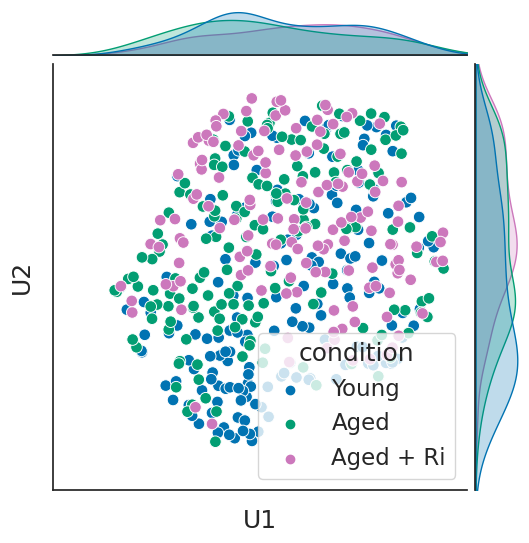

In [16]:
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)
sns.set_style("white")
# Create the UMAP object
reducer = umap.UMAP(
    min_dist=0.3,
    n_neighbors=15,
    n_components=2,
    random_state=2024,
    metric="euclidean",
)

# Extract numerical data
x = subset_df[sig_f_both].values

# Learn the scaler on the young and confined cells and apply
# it to the old and treated cells
transformer = StandardScaler()
x = transformer.fit_transform(x)

# Learn the UMAP on the young and confined cells and apply
# it to the old and treated cells
embedding = reducer.fit_transform(x)
umap_df = pd.DataFrame(data=embedding, columns=["U1", "U2"])
umap_df = pd.concat([umap_df, subset_df[features]], axis=1)

plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    s=70,
    palette=palette,
    height=6,
    ratio=8,
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

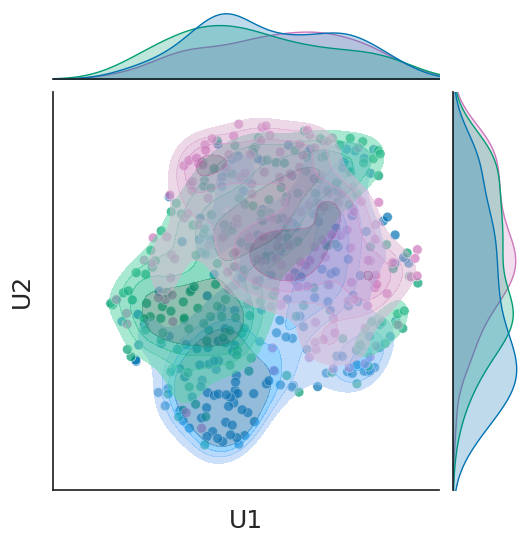

In [17]:
sns.set(font_scale=1.5)
sns.set_style("white")

plt.figure(figsize=(10, 6))

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
    alpha=0.7,
    legend=False,
)
plot.plot_joint(
    sns.kdeplot,
    data=umap_df,
    hue="condition",
    kind="kde",
    fill=True,
    levels=5,
    thresh=0.3,
    alpha=0.5,
    bw_adjust=0.75,
    palette=palette,
    legend=False,
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

Original shape: (485, 20)


<Figure size 1000x600 with 0 Axes>

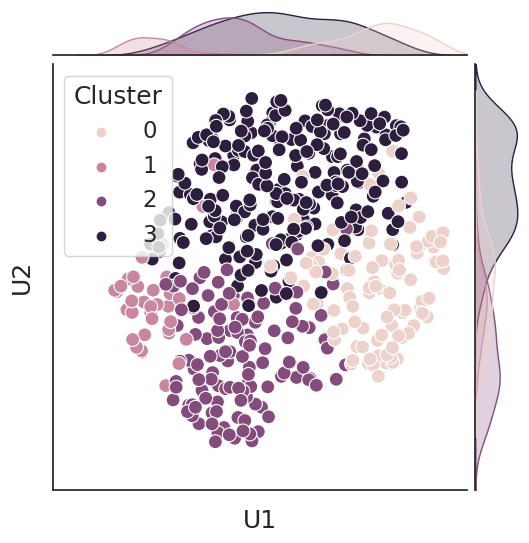

In [20]:
plt.figure(figsize=(10, 6))

# Perform clustering using the original numerical values
X = pd.DataFrame(x, columns=sig_f_both)
print(f"Original shape: {X.shape}")
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
umap_df["Cluster"] = kmeans.labels_
plot = sns.jointplot(
    data=umap_df, x="U1", y="U2", hue="Cluster", s=100, height=6, ratio=8
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])
plt.show()

PCA shape: (485, 13)
Explained variance ratio: 0.958


<Figure size 1000x600 with 0 Axes>

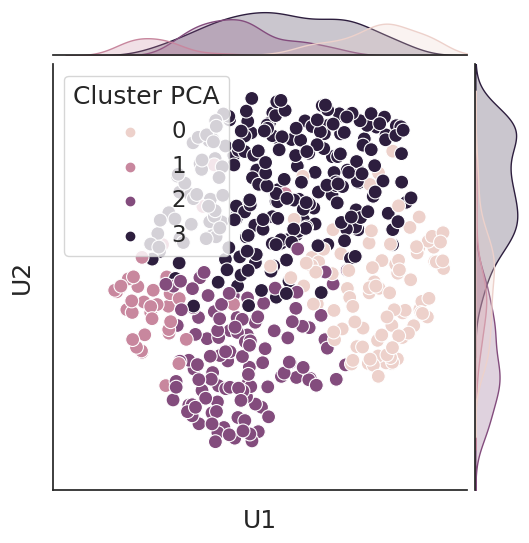

In [21]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 6))

# Apply PCA (you can adjust n_components based on your needs)
pca = PCA(n_components=0.95)  # Keep 95% of variance

X_pca = pca.fit_transform(X)
print(f"PCA shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# Perform clustering using PCA-transformed data
kmeans_pca = KMeans(n_clusters=4, random_state=0).fit(X_pca)
umap_df["Cluster PCA"] = kmeans_pca.labels_

plot = sns.jointplot(
    data=umap_df, x="U1", y="U2", hue="Cluster PCA", s=100, height=6, ratio=8
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])
plt.show()

In [22]:
from sklearn.metrics import adjusted_rand_score

# Adjusted Rand Index (ARI) - measures similarity between clusterings
ari = adjusted_rand_score(kmeans.labels_, kmeans_pca.labels_)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.956


Calculating metrics for each k value...
____________________
Number of clusters: 3
Silhouette Score: 0.13059993465862044
Calinski-Harabasz Score: 74.25333688030393
Davies-Bouldin Score: 2.062979957607429
____________________
Number of clusters: 4
Silhouette Score: 0.13725001723664337
Calinski-Harabasz Score: 66.1839002415245
Davies-Bouldin Score: 1.9582821385405458
____________________
Number of clusters: 5
Silhouette Score: 0.10904932205936929
Calinski-Harabasz Score: 58.46042440905228
Davies-Bouldin Score: 2.1840004419870827
____________________
Number of clusters: 6
Silhouette Score: 0.11320799297347463
Calinski-Harabasz Score: 53.11309701709008
Davies-Bouldin Score: 1.990358186733426
____________________
Number of clusters: 7
Silhouette Score: 0.10129984617005551
Calinski-Harabasz Score: 48.68332967113293
Davies-Bouldin Score: 1.9941477500646911


<Figure size 1000x600 with 0 Axes>

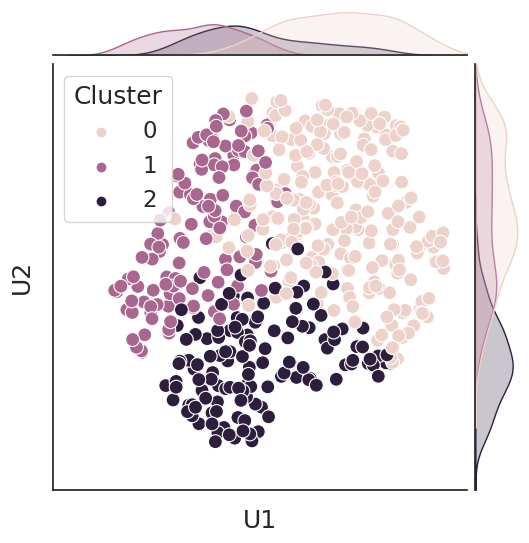

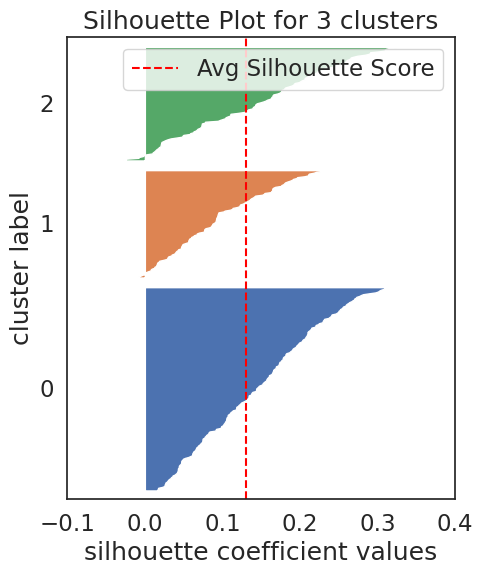

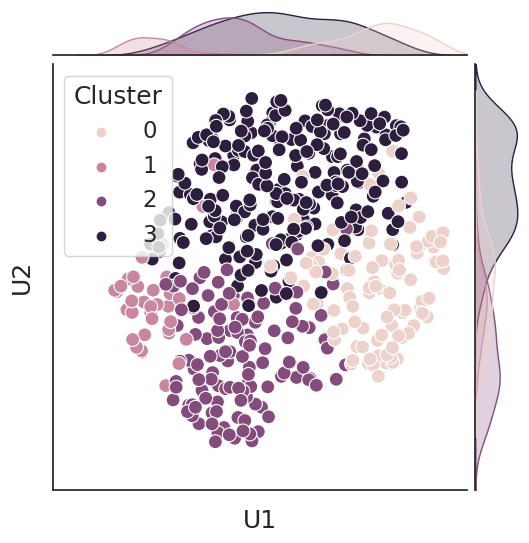

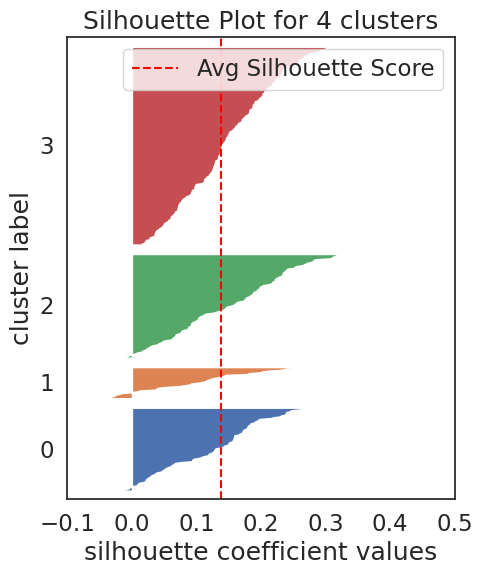

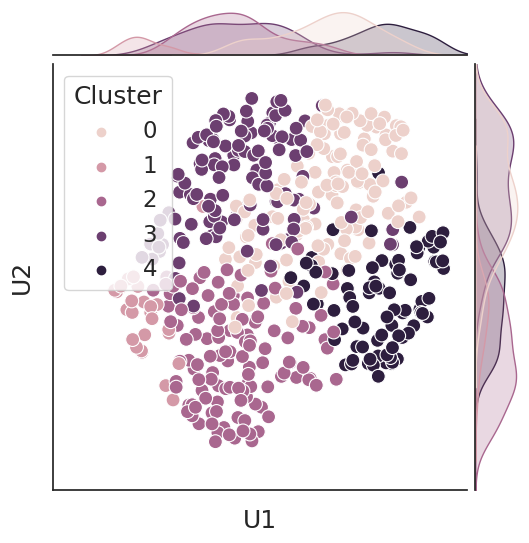

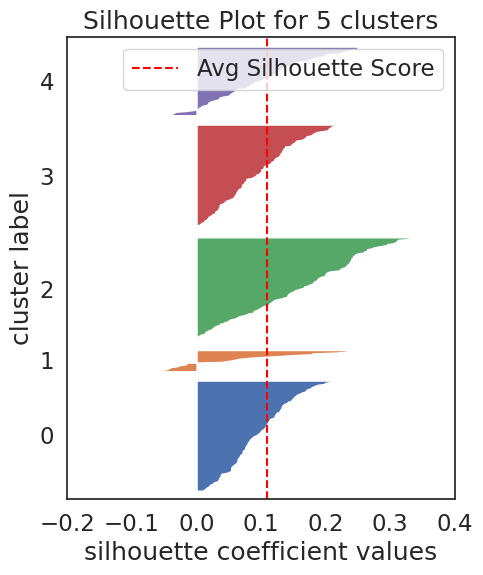

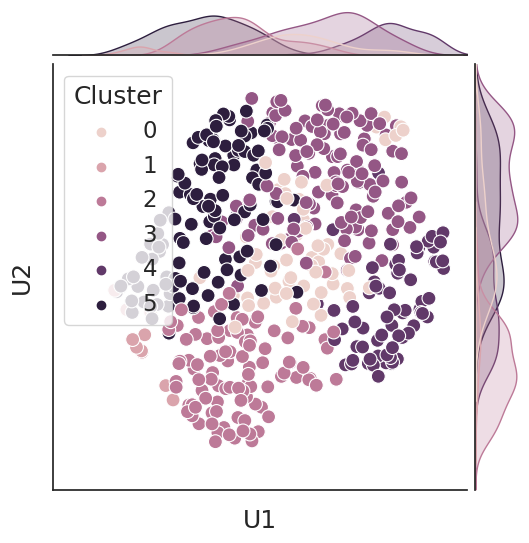

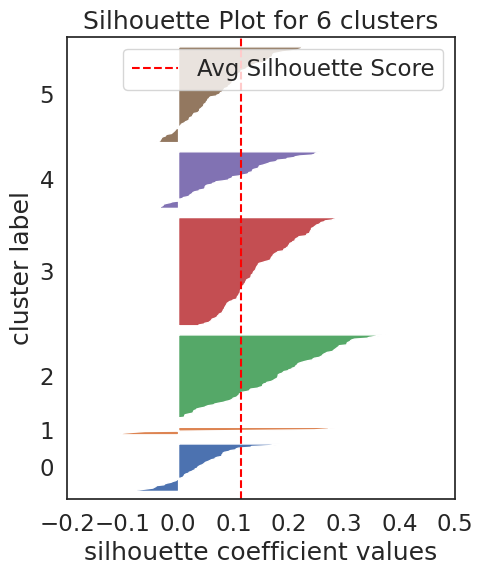

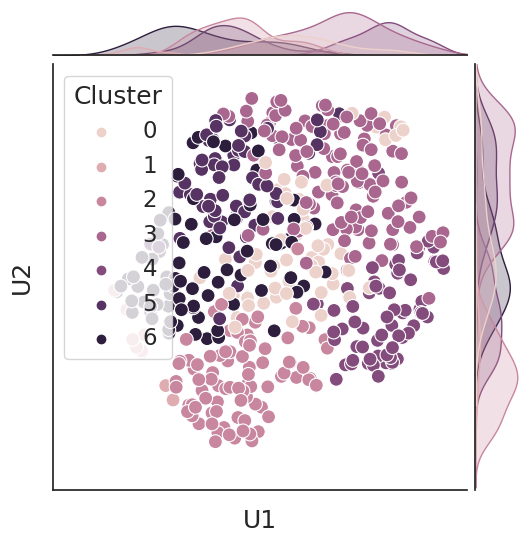

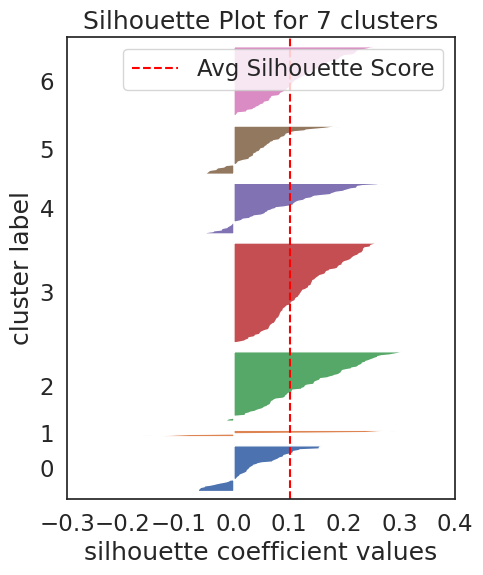

In [23]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

plt.figure(figsize=(10, 6))

# Perform clustering using the original numerical values
X = pd.DataFrame(x, columns=sig_f_both)


# Store metrics for each k
metrics_data = {
    "k": [],
    "silhouette": [],
    "calinski_harabasz": [],
    "davies_bouldin": [],
}

k_range = [3, 4, 5, 6, 7]

# Calculate metrics for each k
print("Calculating metrics for each k value...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

    umap_df["Cluster"] = kmeans.labels_
    plot = sns.jointplot(
        data=umap_df, x="U1", y="U2", hue="Cluster", s=100, height=6, ratio=8
    )
    plot.ax_marg_x.set_xlim(4, 13)
    plot.ax_marg_y.set_ylim(4, 13)
    plot.ax_joint.set(xticklabels=[], yticklabels=[])

    # Plot the silhouette chart to assess the clustering quality
    fig, ax = plt.subplots(figsize=(5, 6))
    hsc.silhouette_plot(x, kmeans, ax)

    # Calculate metrics
    sil_score = silhouette_score(X, kmeans.labels_)
    ch_score = calinski_harabasz_score(X, kmeans.labels_)
    db_score = davies_bouldin_score(X, kmeans.labels_)

    # Store results
    metrics_data["k"].append(k)
    metrics_data["silhouette"].append(sil_score)
    metrics_data["calinski_harabasz"].append(ch_score)
    metrics_data["davies_bouldin"].append(db_score)

    print(f"____________________\nNumber of clusters: {k}")

    print("Silhouette Score:", sil_score)
    print("Calinski-Harabasz Score:", ch_score)
    print("Davies-Bouldin Score:", db_score)

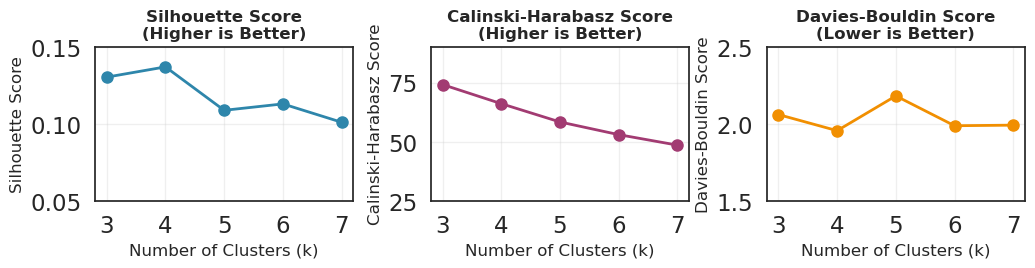

In [24]:
fig = plt.figure(figsize=(12, 2))

# Create a 2x3 grid layout
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

# Plot 1: Silhouette Score
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(
    metrics_data["k"],
    metrics_data["silhouette"],
    "o-",
    linewidth=2,
    markersize=8,
    color="#2E86AB",
)
ax1.set_xlabel("Number of Clusters (k)", fontsize=12)
ax1.set_ylabel("Silhouette Score", fontsize=12)
ax1.set_title(
    "Silhouette Score\n(Higher is Better)", fontsize=12, fontweight="bold"
)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.05, 0.15)
ax1.set_xticks(k_range)

# Plot 2: Calinski-Harabasz Score
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(
    metrics_data["k"],
    metrics_data["calinski_harabasz"],
    "o-",
    linewidth=2,
    markersize=8,
    color="#A23B72",
)
ax2.set_xlabel("Number of Clusters (k)", fontsize=12)
ax2.set_ylabel("Calinski-Harabasz Score", fontsize=12)
ax2.set_title(
    "Calinski-Harabasz Score\n(Higher is Better)",
    fontsize=12,
    fontweight="bold",
)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(25, 90)
ax2.set_xticks(k_range)

# Plot 3: Davies-Bouldin Score
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(
    metrics_data["k"],
    metrics_data["davies_bouldin"],
    "o-",
    linewidth=2,
    markersize=8,
    color="#F18F01",
)
ax3.set_xlabel("Number of Clusters (k)", fontsize=12)
ax3.set_ylabel("Davies-Bouldin Score", fontsize=12)
ax3.set_title(
    "Davies-Bouldin Score\n(Lower is Better)",
    fontsize=12,
    fontweight="bold",
)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(1.5, 2.5)
ax3.set_xticks(k_range)

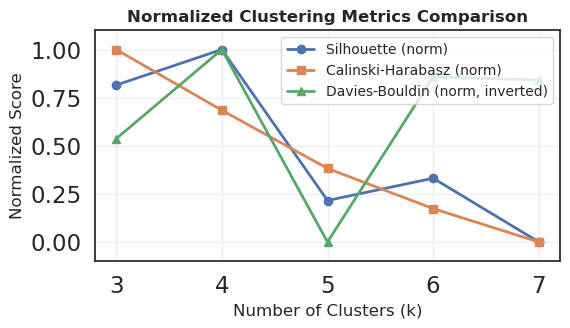

In [25]:
# Plot 4: Combined metrics (normalized)
fig, ax4 = plt.subplots(figsize=(6, 3))

# Normalize metrics to 0-1 scale for comparison
sil_norm = np.array(metrics_data["silhouette"])
sil_norm = (sil_norm - sil_norm.min()) / (sil_norm.max() - sil_norm.min())

ch_norm = np.array(metrics_data["calinski_harabasz"])
ch_norm = (ch_norm - ch_norm.min()) / (ch_norm.max() - ch_norm.min())

db_norm = np.array(metrics_data["davies_bouldin"])
db_norm = 1 - (db_norm - db_norm.min()) / (
    db_norm.max() - db_norm.min()
)  # Invert for consistency

ax4.plot(
    metrics_data["k"],
    sil_norm,
    "o-",
    label="Silhouette (norm)",
    linewidth=2,
    markersize=6,
)
ax4.plot(
    metrics_data["k"],
    ch_norm,
    "s-",
    label="Calinski-Harabasz (norm)",
    linewidth=2,
    markersize=6,
)
ax4.plot(
    metrics_data["k"],
    db_norm,
    "^-",
    label="Davies-Bouldin (norm, inverted)",
    linewidth=2,
    markersize=6,
)

ax4.set_xlabel("Number of Clusters (k)", fontsize=12)
ax4.set_ylabel("Normalized Score", fontsize=12)
ax4.set_title(
    "Normalized Clustering Metrics Comparison",
    fontsize=12,
    fontweight="bold",
)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(k_range)
ax4.set_ylim(-0.1, 1.1)

plt.show()

Clustering stability (ARI): 0.433 ± 0.090


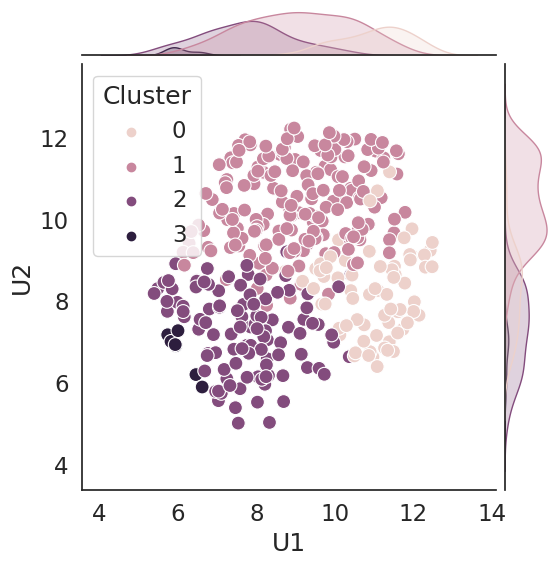

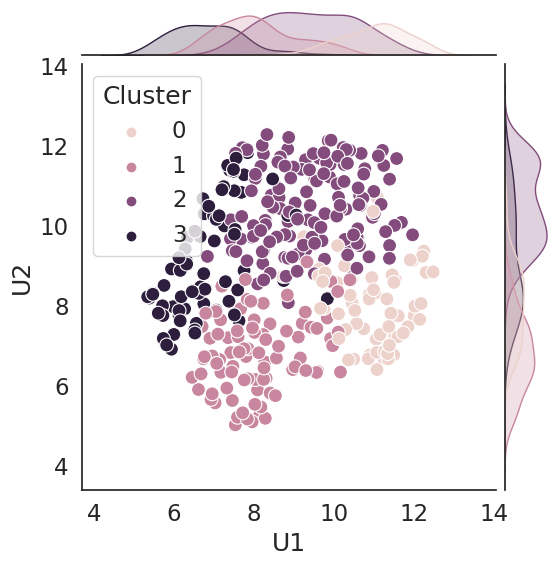

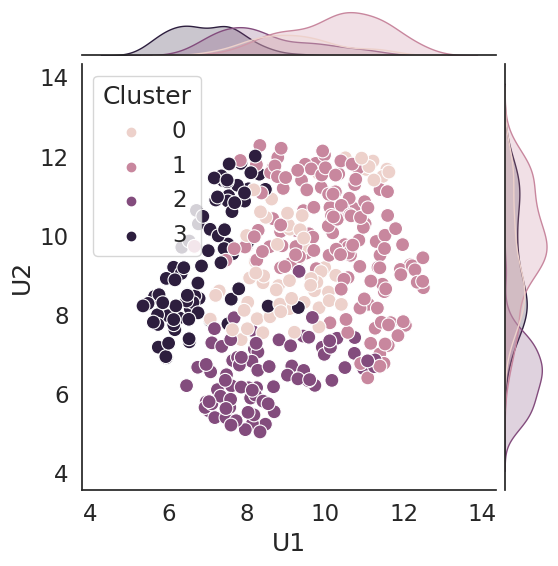

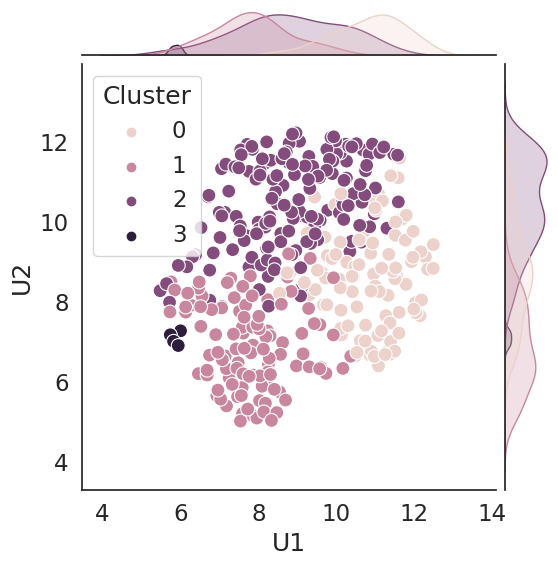

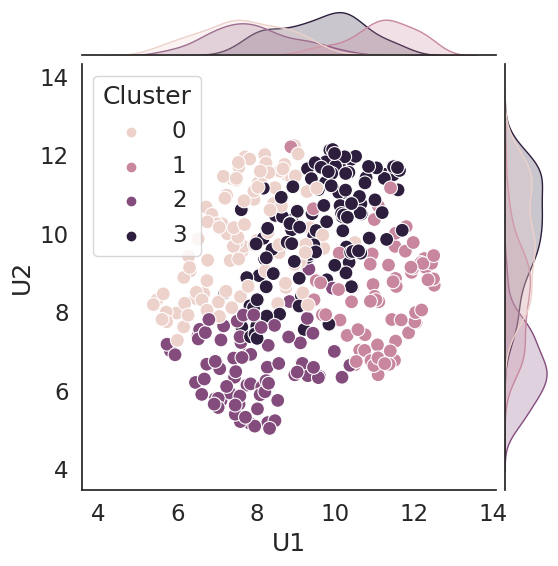

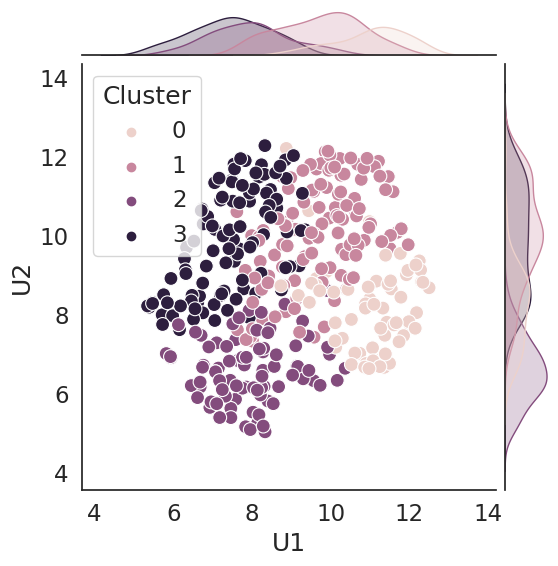

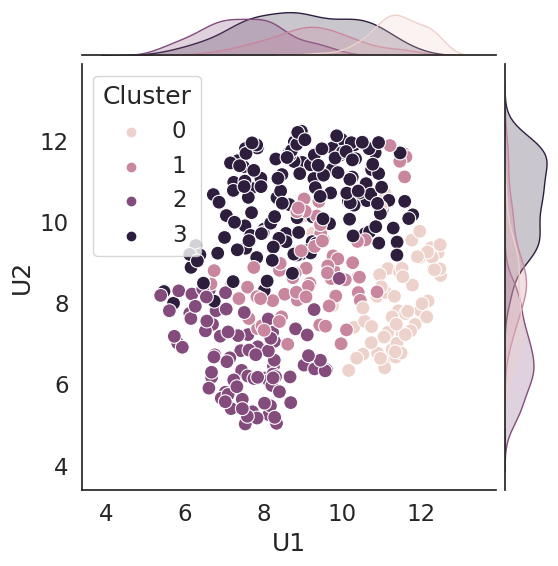

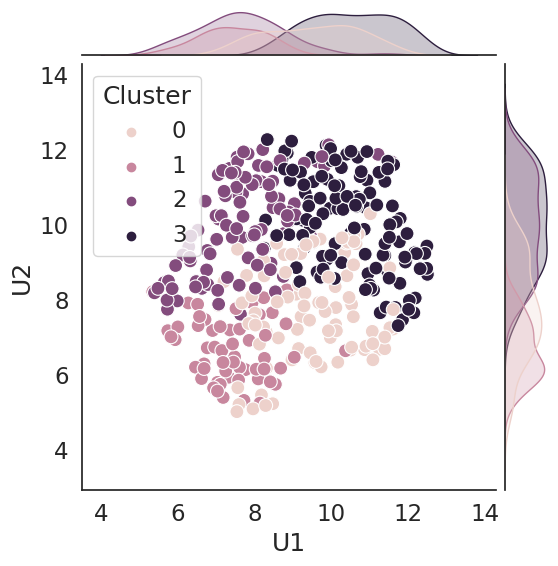

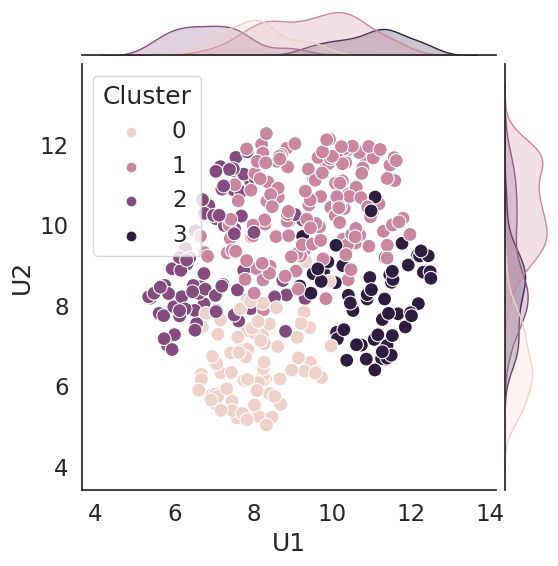

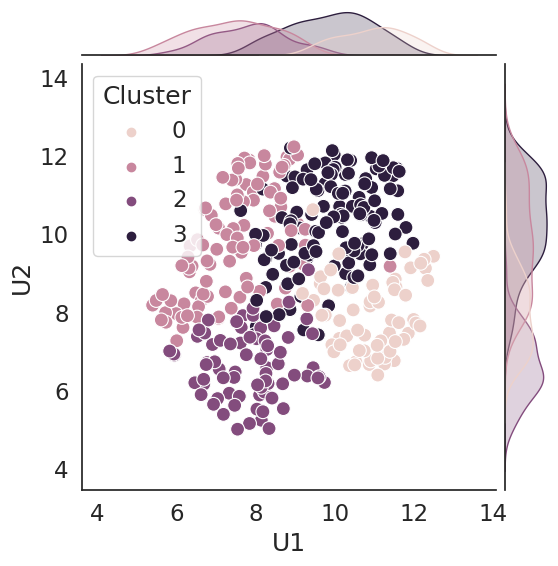

In [26]:
from sklearn.metrics import adjusted_rand_score

# Get your reference clustering
labels_full = KMeans(n_clusters=5, random_state=42).fit_predict(X)

# Test stability with subsampling
ari_scores = []
for i in range(10):
    idx = np.random.choice(
        len(x),
        int(len(x) * 0.75),
        replace=False,
    )  # 50% subsample
    labels_sub = KMeans(n_clusters=4, random_state=0).fit_predict(x[idx])
    ari_scores.append(adjusted_rand_score(labels_full[idx], labels_sub))

    sub_umap_df = umap_df.iloc[idx].copy()
    sub_umap_df["Cluster"] = labels_sub
    plot = sns.jointplot(
        data=sub_umap_df,
        x="U1",
        y="U2",
        hue="Cluster",
        s=100,
        height=6,
        ratio=8,
    )
    # plt.show()


mean_stability = np.mean(ari_scores)
print(
    f"Clustering stability (ARI): {mean_stability:.3f} ± {np.std(ari_scores):.3f}"
)